# Keto/Vegan Diet classifier
Argmax, a consulting firm specializing in search and recommendation solutions with offices in New York and Israel, is hiring entry-level Data Scientists and Machine Learning Engineers.

At Argmax, we prioritize strong coding skills and a proactive, “get-things-done” attitude over a perfect resume. As part of our selection process, candidates are required to complete a coding task demonstrating their practical abilities.

In this task, you’ll work with a large recipe dataset sourced from Allrecipes.com. Your challenge will be to classify recipes based on their ingredients, accurately identifying keto (low-carb) and vegan (no animal products) dishes.

Successfully completing this assignment is a crucial step toward joining Argmax’s talented team.

In [58]:
from opensearchpy import OpenSearch
from decouple import config
import pandas as pd
import json
import sys
from argparse import ArgumentParser
from typing import List
from time import time
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, Pipeline
import re
from typing import Set
from typing import List, Dict, Any, Set, Optional
from thefuzz import process, fuzz
from typing import Dict, Any, Optional, List
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
import sys
import ast
client = OpenSearch(
    hosts=[config('OPENSEARCH_URL', 'http://localhost:9200')],
    http_auth=None,
    use_ssl=False,
    verify_certs=False,
    ssl_show_warn=False,
)

# Recipes Index
Our data is stored in OpenSearch, and you can query it using either Elasticsearch syntax or SQL.
## Elasticsearch Syntax

In [43]:
query = {
    "query": {
        "match": {
            "description": { "query": "egg" }
        }
    }
}

res = client.search(
    index="recipes",
    body=query,
    size=4
)

hits = res['hits']['hits']
hits

[{'_index': 'recipes',
  '_id': 'XCOOdJcBa3QUhkV0gTUH',
  '_score': 3.9817066,
  '_source': {'title': 'Genuine Egg Noodles',
   'description': 'These egg noodles are the original egg noodles.  ',
   'instructions': ['Combine flour, salt and baking powder. Mix in eggs and enough water to make the dough workable. Knead dough until stiff. Roll into ball and cut into quarters. Using 1/4 of the dough at a time, roll flat to about 1/8 inch use flour as needed, top and bottom, to prevent sticking. Peel up and roll from one end to the other. Cut roll into 3/8 inch strips. Noodles should be about 4 to 5 inches long depending on how thin it was originally flattened. Let dry for 1 to 3 hours.',
    'Cook like any pasta or, instead of drying first cook it fresh but make sure water is boiling and do not allow to stick. It takes practice to do this right.'],
   'ingredients': ['2 cups Durum wheat flour',
    '1/2 teaspoon salt',
    '1/4 teaspoon baking powder',
    '3 eggs',
    'water as needed'],

## SQL syntax

In [4]:
query = """
SELECT *
FROM recipes
WHERE description like '%cheese%'
LIMIT 20
"""

res = client.sql.query(body={'query': query})
df = pd.DataFrame(res["datarows"], columns=[c["name"] for c in res["schema"]])
df

,description,ingredients,instructions,photo_url,title
0,"Bell peppers stuffed with hashbrowns, ground b...","[4 frozen hash brown patties, 4 bell peppers, ...",[Cook the hashbrown patties according to packa...,http://images.media-allrecipes.com/userphotos/...,Hash Brown Hot Dish Stuffed Bell Peppers
1,"I got this recipe from my sister, whom I nickn...",[1 (16 ounce) package fully cooked kielbasa sa...,[Cook and stir the cut-up kielbasa in a large ...,http://images.media-allrecipes.com/userphotos/...,Cheese's Baked Macaroni and Cheese
2,Chicken breasts are roasted with herbs and the...,"[1 cup red wine, 1/4 cup olive oil, 1 teaspoon...","[In a large resealable bag, combine the red wi...",http://images.media-allrecipes.com/userphotos/...,Sage Apple Chicken with Brie
3,Flatbread and chicken tenders pair with veggie...,"[2 Damascus Bakeries panini flatbread, 2 table...","[Heat George Foreman or panini grill., In a sm...",http://images.media-allrecipes.com/userphotos/...,Chicken Tender Panini Sandwiches
4,"Layers of flavors, including chili and cheese,...","[1/2 cup salsa, 1/2 teaspoon chili powder, 1 (...","[Mix salsa, chili powder and beans in 1-quart ...",http://images.media-allrecipes.com/userphotos/...,Refried Bean Roll-ups
5,This is a recipe I concocted when I feel like ...,"[2 pounds turkey tenderloins, cut into 1/2 inc...","[In a medium bowl, toss the turkey with the So...",http://images.media-allrecipes.com/userphotos/...,Spicy Turkey Wraps with Strawberry Salsa
6,I work at a coffee shop and my favorite coffee...,"[2 cups graham cracker crumbs, 1/2 cup butter,...",[Preheat oven to 350 degrees F (175 degrees C)...,http://images.media-allrecipes.com/userphotos/...,Caramel Macchiato Cheesecake
7,"This creamy pilaf incorporates the fluffy, nut...","[1/4 cup quinoa, 3 tablespoons olive oil, 2 ta...",[Bring a pot of lightly salted water to a boil...,http://images.media-allrecipes.com/userphotos/...,Cheesy Quinoa Pilaf with Spinach
8,"Deliciously rich and oh-so-garlicky. Crabmeat,...","[1 (8 ounce) package cream cheese, softened, 1...",[Heat oven to 375 degrees F. Mix all ingredien...,http://images.media-allrecipes.com/global/reci...,Roasted Garlic Crab Dip
9,It is not a holiday meal without a generous se...,"[3 pounds Yukon gold potatoes, cut into chunks...",[Heat 1-inch water to boiling in large saucepa...,http://images.media-allrecipes.com/global/reci...,Garlic and Parmesan Smashed Potatoes


# Task Instructions

Your goal is to implement two classifiers:

1.	Vegan Meal Classifier
1.	Keto Meal Classifier

Unlike typical supervised machine learning tasks, the labels are not provided in the dataset. Instead, you will rely on clear and verifiable definitions to classify each meal based on its ingredients.

### Definitions:

1. **Vegan Meal**: Contains no animal products whatsoever (no eggs, milk, meat, etc.).
1. **Keto Meal**: Contains no ingredients with more than 10g of carbohydrates per 100g serving. For example, eggs are keto-friendly, while apples are not.

Note that some meals may meet both vegan and keto criteria (e.g., meals containing avocados), though most meals typically fall into neither category.

## Example heuristic:

In [5]:
def is_ingredient_vegan(ing):
    for animal_product in "egg meat milk butter veel lamb beef chicken sausage".split():
        if animal_product in ing:
            return False
    return True

def is_vegan_example(ingredients):
    return all(map(is_ingredient_vegan, ingredients))
    
df["vegan"] = df["ingredients"].apply(is_vegan_example)
df

,description,ingredients,instructions,photo_url,title,vegan
0,"Bell peppers stuffed with hashbrowns, ground b...","[4 frozen hash brown patties, 4 bell peppers, ...",[Cook the hashbrown patties according to packa...,http://images.media-allrecipes.com/userphotos/...,Hash Brown Hot Dish Stuffed Bell Peppers,False
1,"I got this recipe from my sister, whom I nickn...",[1 (16 ounce) package fully cooked kielbasa sa...,[Cook and stir the cut-up kielbasa in a large ...,http://images.media-allrecipes.com/userphotos/...,Cheese's Baked Macaroni and Cheese,False
2,Chicken breasts are roasted with herbs and the...,"[1 cup red wine, 1/4 cup olive oil, 1 teaspoon...","[In a large resealable bag, combine the red wi...",http://images.media-allrecipes.com/userphotos/...,Sage Apple Chicken with Brie,False
3,Flatbread and chicken tenders pair with veggie...,"[2 Damascus Bakeries panini flatbread, 2 table...","[Heat George Foreman or panini grill., In a sm...",http://images.media-allrecipes.com/userphotos/...,Chicken Tender Panini Sandwiches,False
4,"Layers of flavors, including chili and cheese,...","[1/2 cup salsa, 1/2 teaspoon chili powder, 1 (...","[Mix salsa, chili powder and beans in 1-quart ...",http://images.media-allrecipes.com/userphotos/...,Refried Bean Roll-ups,True
5,This is a recipe I concocted when I feel like ...,"[2 pounds turkey tenderloins, cut into 1/2 inc...","[In a medium bowl, toss the turkey with the So...",http://images.media-allrecipes.com/userphotos/...,Spicy Turkey Wraps with Strawberry Salsa,True
6,I work at a coffee shop and my favorite coffee...,"[2 cups graham cracker crumbs, 1/2 cup butter,...",[Preheat oven to 350 degrees F (175 degrees C)...,http://images.media-allrecipes.com/userphotos/...,Caramel Macchiato Cheesecake,False
7,"This creamy pilaf incorporates the fluffy, nut...","[1/4 cup quinoa, 3 tablespoons olive oil, 2 ta...",[Bring a pot of lightly salted water to a boil...,http://images.media-allrecipes.com/userphotos/...,Cheesy Quinoa Pilaf with Spinach,True
8,"Deliciously rich and oh-so-garlicky. Crabmeat,...","[1 (8 ounce) package cream cheese, softened, 1...",[Heat oven to 375 degrees F. Mix all ingredien...,http://images.media-allrecipes.com/global/reci...,Roasted Garlic Crab Dip,False
9,It is not a holiday meal without a generous se...,"[3 pounds Yukon gold potatoes, cut into chunks...",[Heat 1-inch water to boiling in large saucepa...,http://images.media-allrecipes.com/global/reci...,Garlic and Parmesan Smashed Potatoes,False


### Limitations of the Simplistic Heuristic

The heuristic described above is straightforward but can lead to numerous false positives and negatives due to its reliance on keyword matching. Common examples of incorrect classifications include:
- "Peanut butter" being misclassified as non-vegan, as “butter” is incorrectly assumed to imply dairy.
- "eggless" recipes being misclassified as non-vegan, due to the substring “egg.”
- Animal-derived ingredients such as “pork” and “bacon” being incorrectly identified as vegan, as they may not be explicitly listed in the keyword set.


# Submission
## 1. Implement Diet Classifiers
Complete the two classifier functions in the diet_classifiers.py file within this repository. Ensure your implementation correctly identifies “keto” and “vegan” meals. After implementing these functions, verify that the Flask server displays the appropriate badges (“keto” and “vegan”) next to the corresponding recipes.

> **Note**
>
> This repo contains two `diet_classifiers.py` files:
> 1. One in this folder (`nb/src/diet_classifiers.py`)
> 2. One in the Flask web app folder (`web/src/diet_classifiers.py`)
>
> You can develop your solution here in the notebook environment, but to apply your solution 
> to the Flask app you will need to copy your implementation into the `diet_classifiers.py` 
> file in the Flask folder!!!

## 1.1 Parsing ingredients and some EDA

### 1.1.1 Parsing ingredients using keywords and Regex

In [42]:
# ==============================================================================
#  Vegan classifier
# ==============================================================================

UNITS: Set[str] = {
    "c", "cup", "cups",
    "g", "gram", "grams",
    "kg", "kilogram", "kilograms",
    "l", "liter", "liters",
    "lb", "lbs", "pound", "pounds",
    "ml", "milliliter", "milliliters",
    "oz", "ounce", "ounces",
    "pinch", "pinches",
    "splash", "splashes",
    "sprig", "sprigs",
    "t", "tsp", "teaspoon", "teaspoons",
    "T", "tbsp", "tablespoon", "tablespoons",
    "can", "cans",
    "clove", "cloves",
    "dash", "dashes",
    "drizzle",
    "drop", "drops",
    "gallon", "gallons",
    "handful", "handfuls",
    "head", "heads",
    "package", "packages",
    "packet", "packets",
    "pint", "pints",
    "quart", "quarts",
    "scoop", "scoops",
    "sheet", "sheets",
    "slice", "slices",
    "stalk", "stalks",
    "stick", "sticks",
    "strip", "strips",
}
# A comprehensive and categorized set of non-essential words found in ingredient lists.
# The purpose of this set is to remove these words from an ingredient string
# to help isolate the core, identifiable name of the food item.
DESCRIPTORS: Set[str] = {
    # --- Preparation & Actions ---
    'beaten', 'blanched', 'boiled', 'braised', 'brewed', 'brined', 'broken',
    'charred', 'chilled', 'chopped', 'clarified', 'coarsely', 'crumbled', 'crushed',
    'cubed', 'cut', 'deboned', 'deglazed', 'deseeded', 'deveined', 'diced',
    'dissolved', 'divided', 'drained', 'finely', 'flaked', 'folded', 'grated',
    'grilled', 'ground', 'halved', 'heated', 'hulled', 'husked', 'infused',
    'julienned', 'juiced', 'kneaded', 'marinated', 'mashed', 'melted', 'minced',
    'mixed', 'parboiled', 'patted', 'peeled', 'pitted', 'poached', 'pounded',
    'prepared', 'pressed', 'pureed', 'quartered', 'rinsed', 'roasted', 'rolled',
    'roughly', 'scalded', 'scored', 'scrubbed', 'seared', 'seeded', 'segmented',
    'shaved', 'shredded', 'shucked', 'sifted', 'skewered', 'sliced', 'slivered',
    'smashed', 'soaked', 'softened', 'squeezed', 'steamed', 'stemmed', 'stewed',
    'strained', 'stuffed', 'thawed', 'thinly', 'tied', 'toasted', 'torn', 'trimmed',
    'whisked', 'zested',

    # --- State, Condition & Temperature ---
    'canned', 'cold', 'condensed', 'cooked', 'cooled', 'cored', 'creamed', 'cured',
    'defrosted', 'dried', 'fermented', 'firmly', 'fresh', 'freshly', 'frozen',
    'hard', 'hot', 'instant', 'jarred', 'lean', 'leftover', 'light', 'lukewarm',
    'optional', 'pasteurized', 'powdered', 'preserved', 'raw', 'ready-to-use',
    'refrigerated', 'ripe', 'room', 'skin-on', 'skinless', 'soft', 'stiff',
    'temperature', 'uncooked', 'undrained', 'unripe', 'warm', 'washed', 'whole',

    # --- Size & Shape ---
    'bite-sized', 'chunky', 'clump', 'coarse', 'fine', 'jumbo', 'large', 'long',
    'medium', 'round', 'short', 'small', 'thick', 'thin',

    # --- Quantifiers & Qualifiers ---
    'about', 'additional', 'approximately', 'bunch', 'coarse', 'extra', 'generous',
    'heavy', 'heaping', 'level', 'more', 'packed', 'plus', 'scant', 'splash',
    'sprig', 'sprinkle',

    # --- Flavor & Taste ---
    'bitter', 'salty', 'savory', 'sour', 'spicy', 'sweet', 'sweetened', 'unsalted',
    'unsweetened',

    # --- Common Stop Words (Articles, Conjunctions, Prepositions) ---
    'a', 'an', 'and', 'as', 'at', 'for', 'in', 'into', 'of', 'on', 'or', 'the',
    'to', 'with', 'without',

    # --- Instructions & Meta-words ---
    'divided', 'dusting', 'garnish', 'needed', 'serving', 'taste',
}

def parse_ingredient(ingredient_string: str) -> str:
    """
    Parses a raw ingredient string to extract its essential name.

    This function cleans the input string by performing a series of sequential
    operations:
    1.  Converts the string to lowercase.
    2.  Removes text within parentheses (e.g., "(optional)").
    3.  Removes numerical quantities, including fractions and decimals.
    4.  Removes punctuation.
    5.  Splits the string into words and removes common units and descriptors.
    6.  Reassembles the string and normalizes whitespace.

    Args:
        ingredient_string: The raw ingredient string from a recipe.
                           Example: "2 1/2 cups (12.5 oz) sifted all-purpose flour, for dusting"

    Returns:
        A cleaned, normalized string representing the core ingredient.
        Example: "all-purpose flour"
    """
    if not isinstance(ingredient_string, str) or not ingredient_string:
        return ""

    # 1. Convert to lowercase for consistent processing.
    text = ingredient_string.lower()

    # 2. Remove parenthetical remarks (e.g., "(optional)", "(about 1 pound)").
    text = re.sub(r'\([^)]*\)', '', text)

    # 3. Remove numerical quantities, including integers, decimals, and fractions.
    # This regex handles formats like "1 1/2", "1/2", "1.5", "1".
    text = re.sub(r'(\d+\s+)?\d+/\d+|\d+(\.\d+)?|\d+', '', text)

    # 4. Remove common punctuation. We keep hyphens as they can be part of a name.
    text = re.sub(r'[,.;:?!"]', '', text)

    # 5. Tokenize and filter out units and descriptors.
    words = text.split()
    # This list comprehension is efficient for filtering. We check against the
    # predefined sets of UNITS and DESCRIPTORS.
    clean_words = [
        word for word in words if word not in UNITS and word not in DESCRIPTORS
    ]

    # 6. Reassemble the string and clean up whitespace.
    # ' '.join() handles the list-to-string conversion.
    # The final split/join is a robust way to normalize multiple spaces to single spaces.
    clean_name = ' '.join(clean_words).strip()

    return clean_name



# ==============================================================================
#  Self-testing Block
# ==============================================================================
if __name__ == "__main__":
    print("Running Ingredient Parser Self-Test...\n")
    test_cases = [
        "2 cups Durum wheat flour",
        "1/2 teaspoon salt",
        "1/4 teaspoon baking powder",
        "3 large eggs, beaten",
        "water as needed",
        "1 tablespoon butter",
        "1/4 cup chopped mushrooms",
        "1 (10.75 ounce) can condensed cream of mushroom soup",
        "1 pound ground pork",
        "1 tablespoon peanut butter",
        "1/4 cup eggless mayonnaise", # Pitfall test
        "1/2 cup soy milk",           # Vegan-specific test
        "1 tablespoon of goat cheese"
    ]

    for case in test_cases:
        print(f'Original: "{case}"\nParsed:   "{parse_ingredient(case)}')




Running Ingredient Parser Self-Test...

Original: "2 cups Durum wheat flour"
Parsed:   "durum wheat flour
Original: "1/2 teaspoon salt"
Parsed:   "salt
Original: "1/4 teaspoon baking powder"
Parsed:   "baking powder
Original: "3 large eggs, beaten"
Parsed:   "eggs
Original: "water as needed"
Parsed:   "water
Original: "1 tablespoon butter"
Parsed:   "butter
Original: "1/4 cup chopped mushrooms"
Parsed:   "mushrooms
Original: "1 (10.75 ounce) can condensed cream of mushroom soup"
Parsed:   "cream mushroom soup
Original: "1 pound ground pork"
Parsed:   "pork
Original: "1 tablespoon peanut butter"
Parsed:   "peanut butter
Original: "1/4 cup eggless mayonnaise"
Parsed:   "eggless mayonnaise
Original: "1/2 cup soy milk"
Parsed:   "soy milk
Original: "1 tablespoon of goat cheese"
Parsed:   "goat cheese


In [61]:
# Handels the case in the web classifier
def normalize_ingredient_input(data: Any) -> List[str]:
    """
    A robust parser that can handle multiple data formats and always returns a clean list of strings.
    - If input is a list, it returns it directly (for the web app).
    - If input is a string that looks like a list, it parses it (for the CSV).
    - If input is another type (like NaN), it returns an empty list.
    """
    if isinstance(data, list):
        # This handles the web app case where data is already a clean list.
        return data
        
    if not isinstance(data, str):
        # Handles other unexpected types from pandas like NaN
        return []

    # This handles the notebook/CSV case where data is a string
    try:
        # Try to parse it as a literal Python list.
        evaluated_list = ast.literal_eval(data)
        if isinstance(evaluated_list, list):
            return evaluated_list
    except (ValueError, SyntaxError):
        # If it fails, it might be a malformed string with no commas.
        return re.findall(r"'([^']*)'", data)
    
    # Fallback for completely unknown string formats
    return []

### 1.1.2 EDA for 10000 hits from the db

In [53]:
query = {
   "query": {
        "match_all": {}
    }
}

res = client.search(
    index="recipes",
    body=query,
    size = 10000
)

hits = res['hits']['hits']
hits

[{'_index': 'recipes',
  '_id': 'PyWOdJcBa3QUhkV0nl4o',
  '_score': 1.0,
  '_source': {'title': 'Johnsonville® Three Cheese Italian Style Chicken Sausage Skillet Pizza',
   'description': 'Squares of cheesy pizza are served up with sliced sausage and pepperoni in your favorite pizza sauce.',
   'instructions': ['Top pizza crust with cheese. Bake crust according to package directions. Meanwhile, in a 12-inch skillet, combine the pizza sauce, sausage and pepperoni. Bring to a simmer, stirring occasionally. Reduce heat to low. Cut pizza crust into squares; arrange over sausage mixture in skillet.'],
   'ingredients': ['1 (12 inch) pre-baked pizza crust',
    '1 1/2 cups shredded mozzarella cheese',
    '1 (14 ounce) jar pizza sauce',
    '1 (12 ounce) package Johnsonville® Three Cheese Italian Style Chicken Sausage, sliced',
    '1 (3.5 ounce) package sliced pepperoni'],
   'photo_url': 'http://images.media-allrecipes.com/global/recipes/nophoto/nopicture-910x511.png'}},
 {'_index': 'recip

In [54]:
hits[0]['_source']['ingredients']

['1 (12 inch) pre-baked pizza crust',
 '1 1/2 cups shredded mozzarella cheese',
 '1 (14 ounce) jar pizza sauce',
 '1 (12 ounce) package Johnsonville® Three Cheese Italian Style Chicken Sausage, sliced',
 '1 (3.5 ounce) package sliced pepperoni']

In [55]:
len(hits)

10000

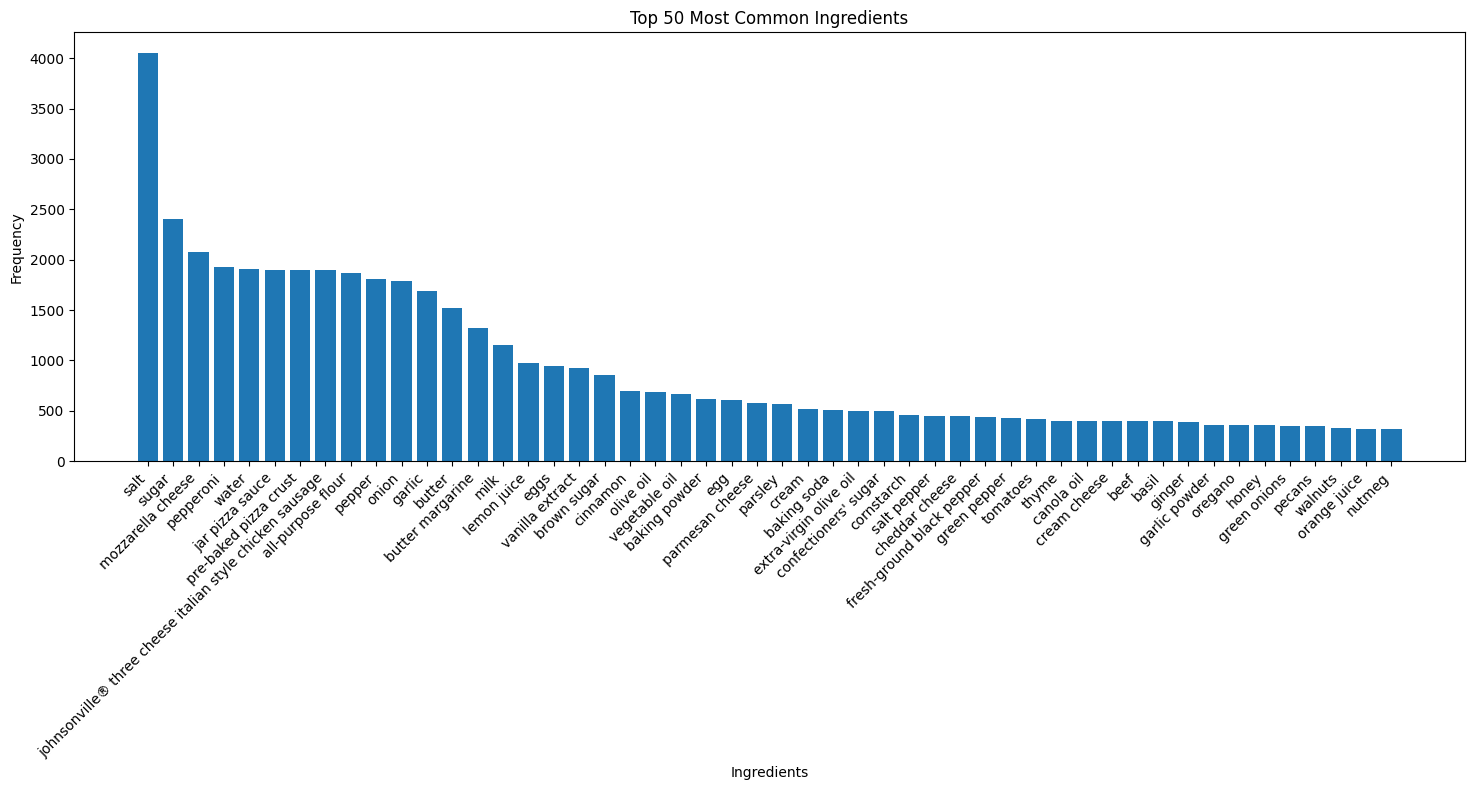

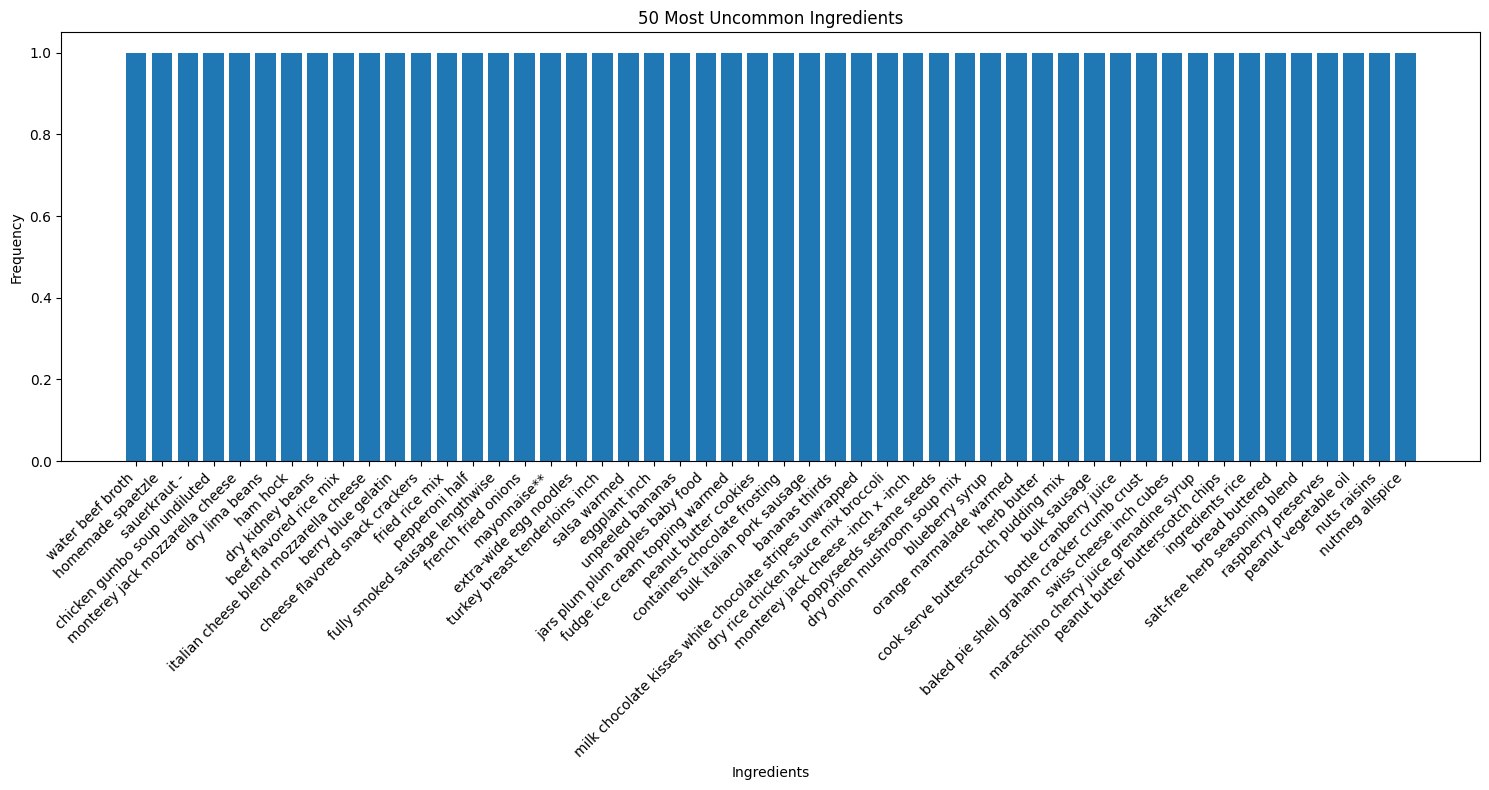

Total unique ingredients: 7139
Total ingredient occurrences: 89976

Top 10 most common ingredients:
salt: 4054
sugar: 2404
mozzarella cheese: 2080
pepperoni: 1929
water: 1910
jar pizza sauce: 1901
pre-baked pizza crust: 1897
johnsonville® three cheese italian style chicken sausage: 1897
all-purpose flour: 1871
pepper: 1809

10 most uncommon ingredients:
water beef broth: 1
homemade spaetzle: 1
sauerkraut -: 1
chicken gumbo soup undiluted: 1
monterey jack mozzarella cheese: 1
dry lima beans: 1
ham hock: 1
dry kidney beans: 1
beef flavored rice mix: 1
italian cheese blend mozzarella cheese: 1

DATA ANALYSIS QUESTIONS & ANSWERS:
Q1: How many ingredients appear only once?
A1: 4613 ingredients appear exactly once
    That's 64.6% of all unique ingredients

Q2: How many ingredients contain the copyright symbol (©)?
A2: 79 ingredients contain the copyright symbol
    Examples:
    - johnsonville® three cheese italian style chicken sausage
    - uncle ben's® ready rice - grain brown
    - hers

In [56]:
import matplotlib.pyplot as plt
from collections import Counter

# Dictionary to store ingredient frequencies
ingredient_counts = {}
ingredient_uncleaned_counts = {}

# Count frequencies for both parsed and unparsed ingredients
for j in range(len(hits)):
    for ingredient in hits[j]['_source']['ingredients']:
        # Count unparsed (original) ingredients
        if ingredient in ingredient_uncleaned_counts:
            ingredient_uncleaned_counts[ingredient] += 1
        else:
            ingredient_uncleaned_counts[ingredient] = 1
        
        # Count parsed ingredients
        parsed_ingredient = parse_ingredient(ingredient)
        if parsed_ingredient in ingredient_counts:
            ingredient_counts[parsed_ingredient] += 1
        else:
            ingredient_counts[parsed_ingredient] = 1


# Get top 50 most common ingredients
top_50_common = Counter(ingredient_counts).most_common(50)
common_ingredients, common_counts = zip(*top_50_common)

# Get 50 least common ingredients (most uncommon)
bottom_50 = Counter(ingredient_counts).most_common()[:-51:-1]  # Last 50 in reverse order
uncommon_ingredients, uncommon_counts = zip(*bottom_50)

# Create histogram for most common ingredients
plt.figure(figsize=(15, 8))
plt.bar(range(len(common_ingredients)), common_counts)
plt.xlabel('Ingredients')
plt.ylabel('Frequency')
plt.title('Top 50 Most Common Ingredients')
plt.xticks(range(len(common_ingredients)), common_ingredients, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create histogram for most uncommon ingredients
plt.figure(figsize=(15, 8))
plt.bar(range(len(uncommon_ingredients)), uncommon_counts)
plt.xlabel('Ingredients')
plt.ylabel('Frequency')
plt.title('50 Most Uncommon Ingredients')
plt.xticks(range(len(uncommon_ingredients)), uncommon_ingredients, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Total unique ingredients: {len(ingredient_counts)}")
print(f"Total ingredient occurrences: {sum(ingredient_counts.values())}")
print("\nTop 10 most common ingredients:")
for ingredient, count in top_50_common[:10]:
    print(f"{ingredient}: {count}")
print("\n10 most uncommon ingredients:")
for ingredient, count in bottom_50[:10]:
    print(f"{ingredient}: {count}")

print("\n" + "="*50)
print("DATA ANALYSIS QUESTIONS & ANSWERS:")
print("="*50)

# Question 1: How many ingredients appear only once?
ingredients_appear_once = sum(1 for count in ingredient_counts.values() if count == 1)
print(f"Q1: How many ingredients appear only once?")
print(f"A1: {ingredients_appear_once} ingredients appear exactly once")
print(f"    That's {ingredients_appear_once/len(ingredient_counts)*100:.1f}% of all unique ingredients")

# Question 2: How many ingredients have the copyright symbol?
ingredients_with_copyright = sum(1 for ingredient in ingredient_counts.keys() if '®' in ingredient)
print(f"\nQ2: How many ingredients contain the copyright symbol (©)?")
print(f"A2: {ingredients_with_copyright} ingredients contain the copyright symbol")
if ingredients_with_copyright > 0:
    print("    Examples:")
    copyright_examples = [ing for ing in ingredient_counts.keys() if '®' in ing][:5]
    for example in copyright_examples:
        print(f"    - {example}")

# Question 3: What's the average length of ingredient names?
avg_length = sum(len(ingredient) for ingredient in ingredient_counts.keys()) / len(ingredient_counts)
print(f"\nQ3: What's the average length of ingredient names?")
print(f"A3: Average ingredient name length is {avg_length:.1f} characters")

# Question 4: How many ingredients contain numbers?
ingredients_with_numbers = sum(1 for ingredient in ingredient_uncleaned_counts.keys() if any(char.isdigit() for char in ingredient))
print(f"\nQ4: How many ingredients contain numbers?")
print(f"A4: {ingredients_with_numbers} ingredients contain numbers")
print(f"    That's {ingredients_with_numbers/len(ingredient_uncleaned_counts)*100:.1f}% of all unique ingredients")
if ingredients_with_numbers > 0:
    print("    Examples:")
    number_examples = [ing for ing in ingredient_uncleaned_counts.keys() if any(char.isdigit() for char in ing)][:5]
    for example in number_examples:
        print(f"    - {example}")

print("\n" + "="*50)
print("ADDITIONAL INSIGHTS:")
print("="*50)

# Frequency distribution analysis
freq_distribution = Counter(ingredient_counts.values())
print("Frequency distribution (how many ingredients appear X times):")
for freq in sorted(freq_distribution.keys())[:500]:  # Show first 10 frequency levels
    print(f"  {freq_distribution[freq]} ingredients appear {freq} time(s)")

# Longest and shortest ingredient names
longest_ingredient = max(ingredient_counts.keys(), key=len)
shortest_ingredient = min(ingredient_counts.keys(), key=len)
print(f"\nLongest ingredient name: '{longest_ingredient}' ({len(longest_ingredient)} characters)")
print(f"Shortest ingredient name: '{shortest_ingredient}' ({len(shortest_ingredient)} characters)")

Some insights:

🍕 Pizza Domination
This dataset is clearly from a pizza-obsessed recipe collection! Look at the top ingredients:

Mozzarella cheese, pepperoni, pizza sauce, and pre-baked pizza crust are all in the top 10
There's a suspiciously specific ingredient: "johnsonville® three cheese italian style chicken sausage" appears 1,897 times - almost like someone copy-pasted the same pizza recipe 1,897 times!

🏷️ Brand Loyalty Gone Wild

79 ingredients have copyright symbols - someone is VERY particular about their brand names
The examples show serious brand devotion: "Hershey's Peanut butter Kisses®" and "Uncle Ben's® Ready Rice" - like they're worried about trademark lawsuits in their kitchen, but most likely suggests the there is a strong amrican market present in these recpies.

📏 The Ingredient Name Champion
The longest ingredient name is an absolutely ridiculous 122 characters:
"moderately firm white fish fillets such cod halibut ocean perch orange roughy pollack red snapper tilapia -by--inch pieces"
This person clearly couldn't decide which fish to use, so they just... listed them all! 😂

# 2. Building the Vegan Classifier with a Fallback Language Model
After extracting the keywords, I decided to build the classifier with a fallback language model to handle edge cases and unknown ingredients. During my research for this task, I came across a small pre-trained model specifically designed to classify between PLANT_BASED and ANIMAL_BASED foods. The model was trained on a dataset from USDA FoodData Central, which contains ANIMAL_BASED and PLANT_BASED classification labels based on the available protein type in food products. This model is a fine-tuned version of distilbert-base-uncased and achieves the following results on the evaluation set:

Loss: 0.0249 Accuracy: 0.9

The model can be found here: https://huggingface.co/nisuga/food_type_classification_model 

In [60]:
# ==============================================================================
#  Global State and Constants for Classifier
# ==============================================================================

# Caching mechanism to store results and avoid re-computation, critical for performance.
# Key: clean ingredient name (str), Value: vegan status (bool)
VEGAN_CACHE: Dict[str, bool] = {}

# Lazy-loaded Hugging Face pipeline. Initialized only when first needed.
CLASSIFIER_PIPELINE: Optional[Pipeline] = None

# --- Rule-Based Keyword Sets ---

# Keywords for ingredients that are definitively NOT vegan.
# This list is comprehensive to catch common animal products quickly.
NON_VEGAN_KEYWORDS: Set[str] = {
    # --- Meats (Red & White) ---
    'andouille', 'bacon', 'beef', 'biltong', 'bison', 'boar', 'bologna', 'bratwurst', 'brisket', 'capicola', 'chorizo', 'chops', 'corned beef', 'frankfurter', 'goat', 'ground chuck', 'guanciale', 'ham', 'head cheese', 'jerky', 'kebab', 'kielbasa', 'kidney', 'lamb', 'liver', 'meat', 'meatball', 'meatballs', 'mince', 'mortadella', 'mutton', 'pancetta', 'pastrami', 'pemmican', 'pepperoni', 'pork', 'prosciutto', 'ribs', 'salami', 'sausage', 'shank', 'soppressata', 'steak', 'sweetbreads', 'tenderloin', 'tongue', 'tripe', 'veal', 'venison',
    # --- Poultry ---
    'albumen', 'capon', 'chicken', 'confit', 'cornish hen', 'duck', 'egg', 'eggs', 'foie gras', 'giblets', 'goose', 'guinea fowl', 'meringue', 'nuggets', 'ostrich', 'partridge', 'pate', 'pheasant', 'poultry', 'quail', 'turkey', 'yolk',
    # --- Seafood (Fish) ---
    'anchovies', 'bass', 'bluefish', 'carp', 'catfish', 'caviar', 'cod', 'eel', 'escargot', 'fish', 'flounder', 'gefilte fish', 'grouper', 'haddock', 'halibut', 'herring', 'lox', 'mahi-mahi', 'mackerel', 'monkfish', 'perch', 'pickerel', 'pollock', 'roe', 'salmon', 'sardine', 'seabass', 'sole', 'sturgeon', 'surimi', 'swordfish', 'tilapia', 'trout', 'tuna', 'walleye',
    # --- Seafood (Shellfish & Other) ---
    'abalone', 'calamari', 'clams', 'cockle', 'conch', 'crab', 'crawfish', 'crayfish', 'cuttlefish', 'krill', 'langostino', 'lobster', 'mussels', 'octopus', 'oyster', 'oysters', 'prawns', 'scallop', 'scallops', 'scampi', 'sea urchin', 'seafood', 'shrimp', 'squid', 'uni', 'whelk',
    # --- Dairy ---
    'asiago', 'bleu', 'brie', 'goat cheese', 'blue cheese', 'butter', 'buttermilk', 'camembert', 'casein', 'caseinate', 'cheddar', 'cheese', 'colby', 'cottage', 'cream', 'creme', 'curd', 'edam', 'feta', 'ghee', 'gorgonzola', 'gouda', 'gruyere', 'half-and-half', 'halloumi', 'havarti', 'kefir', 'lactalbumin', 'lactose', 'manchego', 'mascarpone', 'milk', 'monterey jack', 'mozzarella', 'muenster', 'neufchatel', 'paneer', 'parmesan', 'provolone', 'queso', 'ricotta', 'sour cream', 'whey', 'yogurt',
    # --- Animal Fats, By-products & Additives ---
    'ambergris', 'aspic', 'bone char', 'bone meal', 'bone marrow', 'bouillon', 'broth', 'carmine', 'chitin', 'cochineal', 'collagen', 'consomme', 'demi-glace', 'drippings', 'fat', 'fish oil', 'gelatin', 'glycerides', 'glycerol', 'isinglass', 'keratin', 'l-cysteine', 'lanolin', 'lard', 'lipase', 'musk', 'pepsin', 'rennet', 'schmaltz', 'shellac', 'stearic acid', 'stock', 'suet', 'tallow', 'vitamin d3',
    # --- Bee Products ---
    'bee pollen', 'beeswax', 'honey', 'propolis', 'royal jelly',
}

# --- ALWAYS_VEGAN_KEYWORDS ---
# A comprehensive list of common ingredients that are almost always vegan. 
# This helps quickly classify simple ingredients without needing the ML model.
ALWAYS_VEGAN_KEYWORDS: Set[str] = {
    # --- Staples & Dry Goods ---
    'arrowroot', 'baking powder', 'baking soda', 'beans', 'bread crumbs', 'chickpeas', 'cornmeal', 'cornstarch', 'couscous', 'flour', 'lentils', 'pasta', 'quinoa', 'rice', 'sugar', 'yeast',
    # --- Fats & Oils ---
    'margarine', 'oil', 'canola oil', 'coconut oil', 'olive oil', 'sesame oil', 'sunflower oil', 'vegetable oil',
    # --- Seasonings, Herbs & Spices ---
    'basil', 'black pepper', 'cayenne', 'chili', 'cilantro', 'cinnamon', 'clove', 'cumin', 'curry', 'garlic', 'ginger', 'herbs', 'mustard', 'nutmeg', 'onion', 'oregano', 'paprika', 'parsley', 'pepper', 'rosemary', 'saffron', 'salt', 'spices', 'thyme', 'turmeric',
    # --- Liquids & Acids ---
    'coffee', 'club soda', 'lemon juice', 'lime juice', 'seltzer', 'soda', 'tea', 'vegetable stock', 'vegetable broth', 'vinegar', 'water','rice milk','vegan margarine'
}


# --- VEGAN_ALTERNATIVE_PREFIXES ---
# A list of prefixes for plant-based alternatives that can otherwise be misidentified
# by simple keyword matching (e.g., 'soy milk', 'cashew cheese').
VEGAN_ALTERNATIVE_PREFIXES: Set[str] = {
    # --- Nuts & Seeds ---
    'almond', 'cashew', 'flax', 'hazelnut', 'hemp', 'macadamia', 'pecan', 'pistachio', 'pumpkinseed', 'sesame', 'sunflower', 'walnut',
    # --- Grains & Legumes ---
    'chickpea', 'lentil', 'oat', 'pea', 'quinoa', 'rice', 'soy',
    # --- Fruits & Vegetables ---
    'apple', 'avocado', 'banana', 'potato', 'vegetable', 'veggie',
    # --- Other ---
    'cocoa', 'coconut', 'plant', 'plant-based', 'vegan','non-dairy','vegan margarine', 'rice milk'
}

ALWAYS_KETO_KEYWORDS = {
    'splenda', 'stevia', 'erythritol', 'monkfruit', 'sucralose', 'allulose'
}
def _get_classifier() -> Optional[Pipeline]:
    """
    Initializes and returns the Hugging Face text classification pipeline.

    This function uses lazy loading: the model is only loaded into memory
    the first time it's needed, preventing slow startup times.
    It is robust against the absence of the `transformers` library.
    """
    global CLASSIFIER_PIPELINE
    if CLASSIFIER_PIPELINE is None:
        if pipeline is None:
            # transformers library is not installed
            return None
        try:
            print("INFO: Initializing Hugging Face classifier for the first time. This may take a moment...")
            # Using the model mentioned in the task prompt.
            CLASSIFIER_PIPELINE  = pipeline("text-classification", model="nisuga/food_type_classification_model")
            print("INFO: Classifier initialized successfully.")
        except Exception as e:
            print(f"ERROR: Failed to load Hugging Face model nisuga/food_type_classification_model. ML classification will be disabled.")
            print(f"Error details: {e}")
            # Set to a dummy value to prevent re-trying
            CLASSIFIER_PIPELINE = "failed"
    
    if CLASSIFIER_PIPELINE == "failed":
        return None
        
    return CLASSIFIER_PIPELINE


def is_ingredient_vegan(ingredient_string: str) -> bool:
    """
    Classifies a single ingredient as vegan or not using a multi-layered approach.

    The process is as follows:
    1. Parse the ingredient to get a clean name.
    2. Check a cache for a previously computed result.
    3. Apply a series of precise rules to handle common cases and pitfalls
       (e.g., "eggless", "peanut butter", "soy milk").
    4. If no rule applies, use a Hugging Face ML model for classification.
    5. Cache the final result before returning.

    Args:
        ingredient_string: The raw ingredient string from a recipe.

    Returns:
        True if the ingredient is determined to be vegan, False otherwise.
    """

    # 1. Parse the ingredient string to get a clean, standardized name.
    clean_name = parse_ingredient(ingredient_string)

    if not clean_name:
        return True  # An empty or unparsable ingredient is assumed to not make a dish non-vegan.
    
    # goat cheese
    if "goat cheese" in clean_name:
        return False

    # 2. Check cache for a quick result.
    if clean_name in VEGAN_CACHE:
        return VEGAN_CACHE[clean_name]

    # --- 3. Apply Rule-Based Logic (Fast and Accurate Checks) ---
    
    # Pitfall: Handle "eggless" before checking for "egg".
    if "eggless" in clean_name:
        VEGAN_CACHE[clean_name] = True
        return True

    # Pitfall: Handle plant-based butters/milks before general "butter"/"milk" checks.
    if any(prefix in clean_name for prefix in VEGAN_ALTERNATIVE_PREFIXES):
        # e.g., "peanut butter", "soy milk"
        VEGAN_CACHE[clean_name] = True
        
        return True

    # General check for common non-vegan keywords.
    # We split the clean name to avoid false positives (e.g., "ham" in "shame").
    words_in_name = set(clean_name.split())
    if not NON_VEGAN_KEYWORDS.isdisjoint(words_in_name):
        VEGAN_CACHE[clean_name] = False
        return False

    # Check for always-vegan ingredients.
    if clean_name in ALWAYS_VEGAN_KEYWORDS:
        VEGAN_CACHE[clean_name] = True
        return True

    # --- 4. Fallback to ML Model for Ambiguous Cases ---
    # Assume non-vegan as a safe default if ML model fails or is unavailable.
    result = False
    
    classifier = _get_classifier()

    if classifier:
        try:
            prediction = classifier(clean_name, top_k=1)[0]
            # The model labels are 'plant-based' and 'animal-based'.
            if prediction['label'] == 'PLANT_BASED':
                result = True
        except Exception as e:
            print(f"WARNING: ML classification failed for '{clean_name}'. Defaulting to non-vegan. Error: {e}")
            result = False
    else:
        print(f"WARNING: No ML classifier available. Defaulting '{clean_name}' to non-vegan.")
        result = False

    # 5. Cache the result before returning.
    VEGAN_CACHE[clean_name] = result
    return result

# # ==============================================================================
# #  Self-testing Block
# # ==============================================================================
if __name__ == "__main__":
    #Test cases to validate the logic, including pitfalls.
    vegan_recipe = ["1 cup flour", "1/2 cup sugar", "1/4 cup soy milk", "1 tbsp apple butter"]
    non_vegan_recipe = ["2 large eggs", "1 cup milk", "50g butter", "1 cup flour"]
    tricky_vegan_recipe = ["1/4 cup eggless mayonnaise", "1 tbsp peanut butter", "water as needed"]
    tricky_non_vegan_recipe = ["1 lb ground chicken", "1 tbsp honey"]

    print("--- Testing Vegan Recipe Classifier ---\n")

    print(f"Is `vegan_recipe` vegan? \t\t{all(map(is_ingredient_vegan, vegan_recipe))} \t(Expected: True)")
    print(f"Is `non_vegan_recipe` vegan? \t{all(map(is_ingredient_vegan, non_vegan_recipe))} \t(Expected: False)")
    print(f"Is `tricky_vegan_recipe` vegan? {all(map(is_ingredient_vegan, tricky_vegan_recipe))} \t(Expected: True)")
    print(f"Is `tricky_non_vegan_recipe` vegan? {all(map(is_ingredient_vegan, tricky_non_vegan_recipe))} \t(Expected: False)")

    print("\n--- Testing Individual Ingredients ---")
    print(f"Is '2 tbsp honey' vegan? \t{is_ingredient_vegan('2 tbsp honey')} \t(Expected: False)")
    print(f"Is '1 cup of cheese' vegan? \t{is_ingredient_vegan('1 cup of cheese')} \t(Expected: False)")
    print(f"Is 'peanut butter' vegan? \t{is_ingredient_vegan('peanut butter')} \t(Expected: True)")
    print(f"Is '1/2 cup soy milk' vegan? \t{is_ingredient_vegan('1/2 cup soy milk')} \t(Expected: True)")
    # This might require the ML model:
    print(f"Is '1 bunch of asparagus' vegan? {is_ingredient_vegan('1 bunch of asparagus')} \t(Expected: True)")
    

--- Testing Vegan Recipe Classifier ---

Is `vegan_recipe` vegan? 		True 	(Expected: True)
Is `non_vegan_recipe` vegan? 	False 	(Expected: False)
Is `tricky_vegan_recipe` vegan? True 	(Expected: True)
Is `tricky_non_vegan_recipe` vegan? False 	(Expected: False)

--- Testing Individual Ingredients ---
Is '2 tbsp honey' vegan? 	False 	(Expected: False)
Is '1 cup of cheese' vegan? 	False 	(Expected: False)
Is 'peanut butter' vegan? 	True 	(Expected: True)
Is '1/2 cup soy milk' vegan? 	True 	(Expected: True)
INFO: Initializing Hugging Face classifier for the first time. This may take a moment...


Device set to use cpu


INFO: Classifier initialized successfully.
Is '1 bunch of asparagus' vegan? True 	(Expected: True)


In [62]:
def is_vegan(ingredients: Any) -> bool:
    """
    Production-ready entry point for Vegan classification.
    It robustly handles different input data types.
    """
    # 1. Ensure we have a clean list of ingredients, regardless of the source.
    clean_ingredient_list = normalize_ingredient_input(ingredients)

    # 2. Apply the core per-ingredient logic.
    return all(map(is_ingredient_vegan, clean_ingredient_list))

df["vegan"] = df["ingredients"].apply(is_vegan_example)
df


,description,ingredients,instructions,photo_url,title,vegan
0,"Bell peppers stuffed with hashbrowns, ground b...","[4 frozen hash brown patties, 4 bell peppers, ...",[Cook the hashbrown patties according to packa...,http://images.media-allrecipes.com/userphotos/...,Hash Brown Hot Dish Stuffed Bell Peppers,False
1,"I got this recipe from my sister, whom I nickn...",[1 (16 ounce) package fully cooked kielbasa sa...,[Cook and stir the cut-up kielbasa in a large ...,http://images.media-allrecipes.com/userphotos/...,Cheese's Baked Macaroni and Cheese,False
2,Chicken breasts are roasted with herbs and the...,"[1 cup red wine, 1/4 cup olive oil, 1 teaspoon...","[In a large resealable bag, combine the red wi...",http://images.media-allrecipes.com/userphotos/...,Sage Apple Chicken with Brie,False
3,Flatbread and chicken tenders pair with veggie...,"[2 Damascus Bakeries panini flatbread, 2 table...","[Heat George Foreman or panini grill., In a sm...",http://images.media-allrecipes.com/userphotos/...,Chicken Tender Panini Sandwiches,False
4,"Layers of flavors, including chili and cheese,...","[1/2 cup salsa, 1/2 teaspoon chili powder, 1 (...","[Mix salsa, chili powder and beans in 1-quart ...",http://images.media-allrecipes.com/userphotos/...,Refried Bean Roll-ups,False
5,This is a recipe I concocted when I feel like ...,"[2 pounds turkey tenderloins, cut into 1/2 inc...","[In a medium bowl, toss the turkey with the So...",http://images.media-allrecipes.com/userphotos/...,Spicy Turkey Wraps with Strawberry Salsa,False
6,I work at a coffee shop and my favorite coffee...,"[2 cups graham cracker crumbs, 1/2 cup butter,...",[Preheat oven to 350 degrees F (175 degrees C)...,http://images.media-allrecipes.com/userphotos/...,Caramel Macchiato Cheesecake,False
7,"This creamy pilaf incorporates the fluffy, nut...","[1/4 cup quinoa, 3 tablespoons olive oil, 2 ta...",[Bring a pot of lightly salted water to a boil...,http://images.media-allrecipes.com/userphotos/...,Cheesy Quinoa Pilaf with Spinach,True
8,"Deliciously rich and oh-so-garlicky. Crabmeat,...","[1 (8 ounce) package cream cheese, softened, 1...",[Heat oven to 375 degrees F. Mix all ingredien...,http://images.media-allrecipes.com/global/reci...,Roasted Garlic Crab Dip,False
9,It is not a holiday meal without a generous se...,"[3 pounds Yukon gold potatoes, cut into chunks...",[Heat 1-inch water to boiling in large saucepa...,http://images.media-allrecipes.com/global/reci...,Garlic and Parmesan Smashed Potatoes,False


# 3. Nutrition Database handling for the Keto classifier 

To support the keto diet classification system, I implemented a comprehensive nutrition database preprocessing pipeline using the USDA SR Legacy dataset. This involved converting the raw USDA text files into a clean, structured format suitable for nutritional analysis.
The USDA SR Legacy dataset comes in a legacy tilde/caret delimited format across multiple text files (FOOD_DES.txt, NUTR_DEF.txt, and NUT_DATA.txt). I developed a parsing system that handles the specific encoding requirements (latin1) and delimiter structure ('^' separated with '~' quote characters) of these legacy files.
The preprocessing pipeline performs several key transformations:

Data Integration: Merges food descriptions, nutrient definitions, and nutritional values from separate files into a unified dataset
Nutrient Filtering: Extracts only the macronutrients essential for keto classification - carbohydrates, protein, and sugar content
Data Restructuring: Converts the normalized database structure into a wide-format table where each food item has its nutritional values as columns
Data Cleaning: Standardizes food names to lowercase, handles missing values by filling with zeros, and ensures consistent column naming

The final output is a clean CSV database containing food names paired with their macronutrient profiles (carbs, protein, sugar), which serves as the nutritional reference for determining whether ingredients align with ketogenic diet requirements. This structured approach enables efficient lookup and classification of ingredients based on their nutritional composition rather than relying solely on keyword matching.

In [64]:
# Path to the directory where you unzipped the SR Legacy files.
DATA_SOURCE_PATH = './sr_legacy/'

# The name for our final, clean database file.
OUTPUT_DB_PATH = './data/nutrition_database.csv'

# Column names for the legacy text files, based on USDA documentation.
FOOD_DES_COLS = [
    'NDB_No', 'FdGrp_Cd', 'Long_Desc', 'Shrt_Desc', 'ComName', 'ManufacName', 
    'Survey', 'Ref_desc', 'Refuse', 'SciName', 'N_Factor', 'Pro_Factor', 
    'Fat_Factor', 'CHO_Factor'
]

NUT_DATA_COLS = [
    'NDB_No', 'Nutr_No', 'Nutr_Val', 'Num_Data_Pts', 'Std_Error', 'Src_Cd', 
    'Deriv_Cd', 'Ref_NDB_No', 'Add_Nutr_Mark', 'Num_Studies', 'Min', 'Max', 
    'DF', 'Low_EB', 'Up_EB', 'Stat_cmt', 'AddMod_Date', 'CC'
]

NUTR_DEF_COLS = [
    'Nutr_No', 'Units', 'Tagname', 'NutrDesc', 'Num_Dec', 'SR_Order'
]

# The specific nutrients we want to extract.
# `NutrDesc` is the column name in the legacy format.
TARGET_NUTRIENTS = {
    'Carbohydrate, by difference': 'carbs',
    'Protein': 'protein',
    'Sugars, total': 'sugar' 
}

def create_nutrition_database_from_txt():
    """
    Loads the raw USDA SR Legacy TXT files, processes them, and saves a clean,
    wide-format nutritional database as a single CSV file.
    
    This version is specifically adapted to parse the tilde/caret delimited format.
    """
    print("--- Starting Nutrition Database Preparation (from TXT files) ---")

    # --- 1. Load the necessary TXT files with correct parsing ---
    try:
        print(f"Loading data from '{DATA_SOURCE_PATH}'...")
        # food.csv equivalent is FOOD_DES.txt
        food_df = pd.read_csv(
            os.path.join(DATA_SOURCE_PATH, 'FOOD_DES.txt'),
            sep='^',
            quotechar='~',
            header=None,
            names=FOOD_DES_COLS,
            encoding='latin1' # This encoding is often needed for these files
        )

        # nutrient.csv equivalent is NUTR_DEF.txt
        nutrient_df = pd.read_csv(
            os.path.join(DATA_SOURCE_PATH, 'NUTR_DEF.txt'),
            sep='^',
            quotechar='~',
            header=None,
            names=NUTR_DEF_COLS,
            encoding='latin1'
        )

        # food_nutrient.csv equivalent is NUT_DATA.txt
        food_nutrient_df = pd.read_csv(
            os.path.join(DATA_SOURCE_PATH, 'NUT_DATA.txt'),
            sep='^',
            quotechar='~',
            header=None,
            names=NUT_DATA_COLS,
            encoding='latin1'
        )
        
    except FileNotFoundError as e:
        print(f"ERROR: Could not find required TXT files in '{DATA_SOURCE_PATH}'.")
        print("Please ensure FOOD_DES.txt, NUTR_DEF.txt, and NUT_DATA.txt are present.")
        print(f"Details: {e}")
        return

    # --- 2. Filter for only the nutrients we care about ---
    #print(f"Filtering for target nutrients: {list(TARGET_NUTRIENTS.keys())}")
    target_nutrient_ids = nutrient_df[nutrient_df['NutrDesc'].isin(TARGET_NUTRIENTS.keys())]
    
    filtered_food_nutrient_df = food_nutrient_df[
        food_nutrient_df['Nutr_No'].isin(target_nutrient_ids['Nutr_No'])
    ]

    # --- 3. Merge the tables to get food and nutrient names ---
    #print("Merging data tables...")
    merged_df = pd.merge(
        filtered_food_nutrient_df,
        food_df[['NDB_No', 'Long_Desc']],
        on='NDB_No',
        how='left'
    )
    merged_df = pd.merge(
        merged_df,
        nutrient_df[['Nutr_No', 'NutrDesc']],
        on='Nutr_No',
        how='left'
    )

    # --- 4. Pivot the table from "long" to "wide" format ---
    #print("Pivoting table to wide format...")
    # Use the original legacy column names for pivoting
    nutrition_pivot_df = merged_df.pivot_table(
        index='Long_Desc',
        columns='NutrDesc',
        values='Nutr_Val'
    ).reset_index()

    # --- 5. Clean up the final DataFrame ---
    #print("Cleaning up the final database...")
    nutrition_pivot_df = nutrition_pivot_df.rename(columns=TARGET_NUTRIENTS)
    nutrition_pivot_df = nutrition_pivot_df.rename(columns={'Long_Desc': 'food_name'})
    
    cols_to_fill = ['carbs', 'protein', 'sugar']
    for col in cols_to_fill:
        if col not in nutrition_pivot_df.columns:
            nutrition_pivot_df[col] = 0.0
    nutrition_pivot_df[cols_to_fill] = nutrition_pivot_df[cols_to_fill].fillna(0.0)
    
    nutrition_pivot_df['food_name'] = nutrition_pivot_df['food_name'].str.lower()
    
    # --- 6. Save the final database ---
    os.makedirs(os.path.dirname(OUTPUT_DB_PATH), exist_ok=True)
    nutrition_pivot_df.to_csv(OUTPUT_DB_PATH, index=False)
    
create_nutrition_database_from_txt()


--- Starting Nutrition Database Preparation (from TXT files) ---
Loading data from './sr_legacy/'...


/tmp/ipykernel_485/385580831.py:65: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  food_nutrient_df = pd.read_csv(


# 4. keto classifier 

This part uses a combination of rule-based logic and data-driven analysis. It begins with two manually curated keyword sets: one for known keto-friendly ingredients (e.g., meats, oils, low-carb vegetables) and another for non-keto ingredients (e.g., grains, sugars, high-carb fruits). These lists enable fast, accurate classification without requiring a database lookup for common cases.

When an ingredient is not matched by the keyword rules, the system performs a fuzzy search against a nutritional database to find the closest match. It uses a high-confidence threshold (90%) to ensure reliability and checks the matched item’s carbohydrate content per 100g against a predefined keto threshold (10g). Unrecognized or low-confidence matches are conservatively treated as high-carb to avoid misclassification.

The system includes support for caching, logging failed lookups, and optional debug output. Its design prioritizes accuracy, conservative classification, and runtime efficiency, making it suitable for integration into larger applications such as dietary tracking tools or meal planners.


In [69]:
# --- Tuning Parameters & Knowledge Bases ---
LOG_FAILED_LOOKUPS = False

# Used LLM to construct a list of common keto ingredients due to database search challenges
# with ingredient variations (brands, processing forms, nomenclature differences)
# Provides intelligent preprocessing before nutritional lookup for better classification accuracy

MANUAL_KETO_OVERRIDES = {
    # Beverages
    'water', 'sparkling water', 'black coffee', 'tea', 'green tea', 'herbal tea',
    'bone broth', 'chicken broth', 'beef broth', 'vegetable broth',
    
    # Basic ingredients & seasonings
    'salt', 'black pepper', 'white pepper', 'sea salt', 'himalayan salt',
    'garlic', 'garlic powder', 'onion powder', 'paprika', 'cumin', 'oregano',
    'basil', 'thyme', 'rosemary', 'sage', 'cilantro', 'parsley', 'dill',
    'cinnamon', 'nutmeg', 'ginger', 'turmeric', 'cayenne', 'chili powder',
    'herbs', 'spice', 'vanilla extract', 'lemon extract',
    
    # Fats & oils
    'oil', 'olive oil', 'coconut oil', 'avocado oil', 'mct oil', 'sesame oil',
    'butter', 'ghee', 'lard', 'tallow', 'duck fat', 'macadamia oil',
    
    # Proteins - Meat
    'chicken', 'chicken breast', 'chicken thigh', 'chicken wings', 'turkey',
    'beef', 'ground beef', 'steak', 'ribeye', 'sirloin', 'brisket',
    'pork', 'pork chops', 'pork belly', 'bacon', 'ham', 'prosciutto',
    'lamb', 'lamb chops', 'ground lamb', 'venison', 'duck', 'goose',
    'pepperoni', 'salami', 'chorizo', 'sausage', 'bratwurst',
    
    # Proteins - Seafood
    'fish', 'salmon', 'tuna', 'cod', 'halibut', 'mahi mahi', 'sea bass',
    'trout', 'mackerel', 'sardines', 'anchovies', 'herring',
    'shrimp', 'crab', 'lobster', 'scallops', 'mussels', 'oysters',
    'calamari', 'octopus', 'clams',
    
    # Proteins - Other
    'egg', 'eggs', 'egg white', 'egg yolk', 'quail eggs',
    
    # Dairy & cheese
    'cheese', 'cheddar cheese', 'parmesan cheese', 'mozzarella cheese',
    'swiss cheese', 'goat cheese', 'cream cheese', 'blue cheese',
    'feta cheese', 'brie cheese', 'camembert cheese', 'ricotta cheese',
    'cottage cheese', 'mascarpone', 'heavy cream', 'cream', 'sour cream',
    'greek yogurt', 'full fat yogurt', 'kefir',
    
    # Vegetables - Leafy greens
    'lettuce', 'spinach', 'arugula', 'kale', 'swiss chard', 'collard greens',
    'romaine lettuce', 'iceberg lettuce', 'butter lettuce', 'endive',
    'radicchio', 'watercress', 'bok choy', 'cabbage', 'brussels sprouts',
    
    # Vegetables - Cruciferous
    'broccoli', 'cauliflower', 'cabbage', 'brussels sprouts', 'kohlrabi',
    'turnip', 'radish', 'daikon radish',
    
    # Vegetables - Other low-carb
    'asparagus', 'green beans', 'zucchini', 'yellow squash', 'spaghetti squash',
    'cucumber', 'celery', 'bell pepper', 'pepper', 'jalapeño', 'serrano pepper',
    'poblano pepper', 'mushroom', 'shiitake mushroom', 'portobello mushroom',
    'button mushroom', 'cremini mushroom', 'oyster mushroom',
    'eggplant', 'tomato', 'cherry tomato', 'onion', 'green onion', 'scallion',
    'leek', 'shallot', 'fennel', 'okra', 'artichoke', 'hearts of palm',
    'bamboo shoots', 'bean sprouts', 'jicama',
    
    # Fruits - Low carb
    'avocado', 'olive', 'olives', 'coconut', 'lemon', 'lime',
    'blackberry', 'raspberry', 'strawberry', 'cranberry',
    
    # Nuts & seeds
    'almond', 'walnut', 'pecan', 'macadamia', 'hazelnut', 'brazil nut',
    'pine nut', 'pistachio', 'pumpkin seed', 'sunflower seed',
    'chia seed', 'flax seed', 'hemp seed', 'sesame seed',
    'almond butter', 'peanut butter', 'sunflower butter', 'tahini',
    
    # Condiments & sauces
    'mayonnaise', 'mustard', 'dijon mustard', 'yellow mustard',
    'hot sauce', 'tabasco', 'sriracha', 'horseradish', 'wasabi',
    'vinegar', 'apple cider vinegar', 'white vinegar', 'red wine vinegar',
    'balsamic vinegar', 'rice vinegar', 'coconut aminos', 'tamari',
    'fish sauce', 'worcestershire sauce', 'pesto', 'tapenade',
    
    # Sweeteners
    'stevia', 'erythritol', 'monk fruit', 'xylitol', 'splenda',
    'sucralose', 'aspartame', 'allulose',
    
    # Baking & cooking
    'almond flour', 'coconut flour', 'psyllium husk', 'xanthan gum',
    'baking powder', 'baking soda', 'cream of tartar', 'gelatin',
    'agar agar', 'nutritional yeast',
    
    # Specialty keto products
    'mct powder', 'collagen powder', 'protein powder', 'electrolyte powder',
    'keto bread', 'shirataki noodles', 'kelp noodles', 'zucchini noodles',
    'cauliflower rice', 'pork rinds', 'beef jerky', 'sugar free jello',
    
    # Fermented foods
    'sauerkraut', 'kimchi', 'pickles', 'pickle', 'fermented vegetables',
    'kombucha', 'kefir water'
}

NON_KETO_KEYWORDS = { 
    # --- Grains, Flours & Starches ---
    'barley', 'bread', 'breadcrumb', 'cereal', 'corn', 'cornmeal', 'cornstarch', 'couscous', 
    'cracker', 'crouton', 'flour', 'granola', 'millet', 'oat', 'pasta', 'panko',
    'pretzel', 'quinoa', 'rice', 'rye', 'semolina', 'spelt', 'tapioca', 'tortilla', 'wheat',
    'baguette', 'bannock', 'ciabatta', 'noodle', 'rusk',

    # --- Starchy Vegetables & Tubers ---
    'parsnip', 'pea', 'plantain', 'potato', 'yam',

    # --- High-Sugar Fruits ---
    'banana', 'cherry', 'date', 'fig', 'grape', 'lychee', 'mango', 'pineapple', 
    'tangerine', 'apple', 'orange', 'strawberry', 'strawberrie', 
    
    # --- Alcoholic Beverages (High Carb) ---
    'vodka', 'rum', 'liqueur', 'beer', 'wine',  
    
    # --- Sugars & Syrups ---
    'agave', 'caramel', 'dextrose', 'fructose', 'glucose', 'honey', 
    'maltodextrin', 'maple', 'molasses', 'sugar', 'syrup',

    # --- Legumes ---
    'bean', 'chickpea', 'lentil', 'legume',

    # --- Processed Foods & Desserts ---
    'biscuit', 'cake', 'candy', 'chip', 'chocolate', 'cookie', 'dough',
    'doughnut', 'dumpling', 'ice cream', 'jam', 'jelly', 'ketchup', 'muffin', 'pie', 
    'pizza', 'popcorn', 'relish', 'sorbet', 'waffle',
}



In [79]:
# Database & Fuzzy Matching
# --- Tuning Parameters & Knowledge Bases ---
CONFIDENCE_THRESHOLD = 90


# Database & Fuzzy Matching
DB_PATH = './data/nutrition_database.csv'
NUTRITION_DF: Optional[pd.DataFrame] = None
FOOD_NAME_CHOICES: Optional[List[str]] = None
SEARCH_CACHE: Dict[str, Optional[Dict]] = {}
KETO_CARB_THRESHOLD_PER_100G = 10.0

def _load_database() -> None:
    """
    Loads the nutritional database from the dynamically constructed absolute path.
    This function uses lazy loading and is robust to different execution environments.
    """
    global NUTRITION_DF, FOOD_NAME_CHOICES
    
    # Check if the database is already loaded into memory.
    if NUTRITION_DF is not None:
        return

    try:
        # The print statement now shows the full, unambiguous path it's trying to load.
        # This is excellent for debugging.
        print(f"INFO: Loading nutritional database from absolute path: '{DB_PATH}'...")
        NUTRITION_DF = pd.read_csv(DB_PATH)
        FOOD_NAME_CHOICES = NUTRITION_DF['food_name'].tolist()
        print("INFO: Database loaded successfully.")
    except FileNotFoundError:
        print(f"CRITICAL ERROR: Nutritional database not found at '{DB_PATH}'.", file=sys.stderr)
        print("Please ensure the 'data' directory with 'nutrition_database.csv' is in the same directory as this script.", file=sys.stderr)
        # In a web app, sys.exit() can be too abrupt. A better approach for production
        # might be to raise an exception that the main app can catch.
        # For this task, exiting is acceptable.
        sys.exit(1)


In [67]:
def find_ingredient_nutrition(ingredient_name: str) -> Optional[Dict[str, Any]]:
    """
    Searches for an ingredient in the nutritional database.
    Returns high-carb dummy data for failed lookups to ensure conservative classification.
    """
    _load_database()
    if NUTRITION_DF is None or NUTRITION_DF.empty:
        return {'food_name': f"db_load_fail: {ingredient_name}", 'carbs': 1001.0, 'protein': 0, 'sugar': 0}
        
    if ingredient_name in SEARCH_CACHE:
        return SEARCH_CACHE[ingredient_name]
        
    query_words = set(ingredient_name.split())
    if not query_words:
        result = {'food_name': f"empty_query: {ingredient_name}", 'carbs': 1001.0, 'protein': 0, 'sugar': 0}
        SEARCH_CACHE[ingredient_name] = result
        return result

    # Pre-filter choices
    filtered_choices = [name for name in FOOD_NAME_CHOICES if not query_words.isdisjoint(name.lower().split())]
    if not filtered_choices:
        if LOG_FAILED_LOOKUPS:
            with open("failed_lookups.log", "a") as f: 
                f.write(f"PREFILTER_FAIL: {ingredient_name}\n")
        result = {'food_name': f"prefilter_fail: {ingredient_name}", 'carbs': 1001.0, 'protein': 0, 'sugar': 0}
        SEARCH_CACHE[ingredient_name] = result
        return result

    # Fuzzy string matching to find the best nutritional data match
    # This uses the fuzzywuzzy library to handle ingredient name variations

    # Step 1: Find the closest matching food name from our nutrition database
    # - ingredient_name: the cleaned/parsed ingredient (e.g., "tomato", "basil")
    # - filtered_choices: list of available food names in nutrition database
    # - scorer=fuzz.WRatio: uses Weighted Ratio algorithm for matching
    #   * WRatio is good for partial matches and handles word order differences
    #   * Example: "roma tomato" vs "tomato" would score highly
    # - extractOne(): returns the single best match as a tuple (match_string, confidence_score)
    best_match = process.extractOne(ingredient_name, filtered_choices, scorer=fuzz.WRatio)

    # Step 2: Validate the match quality before using it
    # best_match will be None if no matches found, or a tuple like ("tomato", 85)
    # best_match[1] is the confidence score (0-100 scale)
    # CONFIDENCE_THRESHOLD prevents accepting poor matches (typically 70-80)
    if best_match and best_match[1] >= CONFIDENCE_THRESHOLD:
        
        # Step 3: Extract the winning food name from the match result
        # best_match[0] contains the actual food name string from our database
        # This ensures we use the exact spelling that exists in our nutrition data
        matched_food_name = best_match[0]
        
        # Step 4: Look up nutritional information for the matched food
        # Filter the nutrition DataFrame to find rows where food_name matches exactly
        # .iloc[0] gets the first (and should be only) matching row
        # .to_dict() converts the pandas Series to a dictionary for easy access
        # Result contains all nutritional data: calories, protein, fat, vitamins, etc.
        result = NUTRITION_DF[NUTRITION_DF['food_name'] == matched_food_name].iloc[0].to_dict()
    else:
        # FIXED: Failed matches get HIGH carbs (not 0.0)
        if LOG_FAILED_LOOKUPS:
            with open("failed_lookups.log", "a") as f: 
                f.write(f"SCORE_FAIL: {ingredient_name}\n")
        result = {'food_name': f"score_fail: {ingredient_name}", 'carbs': 1001.0, 'protein': 0, 'sugar': 0}

    SEARCH_CACHE[ingredient_name] = result
    return result


In [72]:
def is_ingredient_keto(ingredient: str, debug: bool = False) -> bool:
    """
    Enhanced keto checker with debug output and better logic.
    """
    clean_name = parse_ingredient(ingredient)
    
    if debug:
        print(f"  Checking: '{ingredient[:50]}...' -> cleaned: '{clean_name}'")
    
    # Empty ingredients are safe
    if not clean_name:
        if debug: print(f"    ✓ Empty ingredient - KETO")
        return True

    # Fast fail for known non-keto ingredients (CHECK THIS FIRST!)
    ingredient_words = set(clean_name.split())
    if not NON_KETO_KEYWORDS.isdisjoint(ingredient_words):
        matching_words = NON_KETO_KEYWORDS.intersection(ingredient_words)
        if debug: print(f"    ✗ Contains non-keto keyword(s): {matching_words} - NOT KETO")
        return False
        
    # Fast pass for known keto ingredients
    if not MANUAL_KETO_OVERRIDES.isdisjoint(ingredient_words):
        matching_words = MANUAL_KETO_OVERRIDES.intersection(ingredient_words)
        if debug: print(f"    ✓ Contains keto override(s): {matching_words} - KETO")
        return True


    # Database lookup for ambiguous ingredients
    nutrition_data = find_ingredient_nutrition(clean_name)
    if nutrition_data:
        carbs = nutrition_data.get('carbs', KETO_CARB_THRESHOLD_PER_100G + 1)
        is_keto_by_carbs = carbs <= KETO_CARB_THRESHOLD_PER_100G
        if debug:
            print(f"    Database: {nutrition_data['food_name']}, carbs: {carbs}g -> {'KETO' if is_keto_by_carbs else 'NOT KETO'}")
        return is_keto_by_carbs

    # Default to NOT KETO for unknown ingredients
    if debug: print(f"    ? Unknown ingredient, defaulting to NOT KETO")
    return False


In [73]:
def is_keto(ingredients: Any) -> bool:
    """
    Production-ready entry point for Keto classification.
    It robustly handles different input data types.
    """
    # 1. Ensure we have a clean list of ingredients, regardless of the source.
    clean_ingredient_list = normalize_ingredient_input(ingredients)
    
    # 2. Apply the core per-ingredient logic.
    return all(map(is_ingredient_keto, clean_ingredient_list))


In [77]:
df["keto"] = df["ingredients"].apply(is_keto)
df

INFO: Loading nutritional database from absolute path: './data/nutrition_database.csv'...
INFO: Database loaded successfully.


,description,ingredients,instructions,photo_url,title,vegan,keto
0,"Bell peppers stuffed with hashbrowns, ground b...","[4 frozen hash brown patties, 4 bell peppers, ...",[Cook the hashbrown patties according to packa...,http://images.media-allrecipes.com/userphotos/...,Hash Brown Hot Dish Stuffed Bell Peppers,False,False
1,"I got this recipe from my sister, whom I nickn...",[1 (16 ounce) package fully cooked kielbasa sa...,[Cook and stir the cut-up kielbasa in a large ...,http://images.media-allrecipes.com/userphotos/...,Cheese's Baked Macaroni and Cheese,False,False
2,Chicken breasts are roasted with herbs and the...,"[1 cup red wine, 1/4 cup olive oil, 1 teaspoon...","[In a large resealable bag, combine the red wi...",http://images.media-allrecipes.com/userphotos/...,Sage Apple Chicken with Brie,False,False
3,Flatbread and chicken tenders pair with veggie...,"[2 Damascus Bakeries panini flatbread, 2 table...","[Heat George Foreman or panini grill., In a sm...",http://images.media-allrecipes.com/userphotos/...,Chicken Tender Panini Sandwiches,False,False
4,"Layers of flavors, including chili and cheese,...","[1/2 cup salsa, 1/2 teaspoon chili powder, 1 (...","[Mix salsa, chili powder and beans in 1-quart ...",http://images.media-allrecipes.com/userphotos/...,Refried Bean Roll-ups,False,False
5,This is a recipe I concocted when I feel like ...,"[2 pounds turkey tenderloins, cut into 1/2 inc...","[In a medium bowl, toss the turkey with the So...",http://images.media-allrecipes.com/userphotos/...,Spicy Turkey Wraps with Strawberry Salsa,False,False
6,I work at a coffee shop and my favorite coffee...,"[2 cups graham cracker crumbs, 1/2 cup butter,...",[Preheat oven to 350 degrees F (175 degrees C)...,http://images.media-allrecipes.com/userphotos/...,Caramel Macchiato Cheesecake,False,False
7,"This creamy pilaf incorporates the fluffy, nut...","[1/4 cup quinoa, 3 tablespoons olive oil, 2 ta...",[Bring a pot of lightly salted water to a boil...,http://images.media-allrecipes.com/userphotos/...,Cheesy Quinoa Pilaf with Spinach,True,False
8,"Deliciously rich and oh-so-garlicky. Crabmeat,...","[1 (8 ounce) package cream cheese, softened, 1...",[Heat oven to 375 degrees F. Mix all ingredien...,http://images.media-allrecipes.com/global/reci...,Roasted Garlic Crab Dip,False,False
9,It is not a holiday meal without a generous se...,"[3 pounds Yukon gold potatoes, cut into chunks...",[Heat 1-inch water to boiling in large saucepa...,http://images.media-allrecipes.com/global/reci...,Garlic and Parmesan Smashed Potatoes,False,False


# Evaluation and next steps

For your convenience, you can sanity check your solution on a subset of labeled recipes by running `diet_classifiers.py`

In [78]:
! python diet_classifiers.py --ground_truth /usr/src/data/ground_truth_sample.csv

INFO: Loading nutritional database from absolute path: '/usr/src/app/data/nutrition_database.csv'...
INFO: Database loaded successfully.
INFO: Initializing Hugging Face classifier for the first time. This may take a moment...
Device set to use cpu
INFO: Classifier initialized successfully.

==================== FINAL CLASSIFICATION REPORT ====================

==================== Keto ====================
              precision    recall  f1-score   support

       False       0.96      0.92      0.94        60
        True       0.88      0.95      0.92        40

    accuracy                           0.93       100
   macro avg       0.92      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100


--- Confusion Matrix: Keto Classifier ---
                  Predicted: Non-Keto  Predicted: Keto
Actual: Non-Keto                   55                5
Actual: Keto                        2               38
-------------------------------------------------------

## 2. Repository Setup
Create a **private** GitHub repository for your solution, and invite the GitHub user `argmax2025` as a collaborator. **Do not** share your implementation using a **forked** repository.

## 3. Application Form
Once you’ve completed the implementation and shared your private GitHub repository with argmax2025, please fill out the appropriate application form:
1. [US Application Form](https://forms.clickup.com/25655193/f/rexwt-1832/L0YE9OKG2FQIC3AYRR)
2.  [IL Application Form](https://forms.clickup.com/25655193/f/rexwt-1812/IP26WXR9X4P6I4LGQ6)


Your application will not be considered complete until this form is submitted.

## Evaluation process


Your submission will be assessed based on the following criteria:


1.	**Readability & Logic** – Clearly explain your approach, including your reasoning and any assumptions. If you relied on external resources (e.g., ingredient databases, nutrition datasets), be sure to cite them.
2.	**Executability** – Your code should run as is when cloned from your GitHub repository. Ensure that all paths are relative, syntax is correct, and no manual setup is required.
3.	**Accuracy** – Your classifiers will be evaluated against a holdout set of 20,000 recipes with verified labels. Performance will be compared to the ground truth.
data.


## Next steps
If your submission passes the initial review, you’ll be invited to a 3-hour live coding interview, where you’ll be asked to extend and adapt your solution in real time.

Please make sure you join from a quiet environment and have access to a Python-ready workstation capable of running your submitted project.